# Monthly Car Sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False

print("Dataset: Monthly Car Sales")
print("=" * 50)

Importing plotly failed. Interactive plots will not work.


Dataset: Monthly Car Sales


In [2]:
print("\nCARGA Y PREPARACIÓN DE DATOS")
print("-" * 30)

df = pd.read_csv('monthly-car-sales.csv')
print(f"Dimensiones del dataset: {df.shape}")
print(f"Rango de fechas: {df['Month'].iloc[0]} a {df['Month'].iloc[-1]}")

df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)

print(f"Estadísticas descriptivas:")
print(df.describe())

df['Year'] = df.index.year
yearly_avg = df.groupby('Year')['Sales'].mean()
print(f"\nVentas promedio por año:")
for year, avg in yearly_avg.items():
    print(f"   {year}: {avg:,.0f} unidades")


CARGA Y PREPARACIÓN DE DATOS
------------------------------
Dimensiones del dataset: (108, 2)
Rango de fechas: 1960-01 a 1968-12
Estadísticas descriptivas:
              Sales
count    108.000000
mean   14595.111111
std     4525.213913
min     5568.000000
25%    11391.250000
50%    14076.000000
75%    17595.750000
max    26099.000000

Ventas promedio por año:
   1960: 10,187 unidades
   1961: 10,858 unidades
   1962: 12,663 unidades
   1963: 13,827 unidades
   1964: 15,171 unidades
   1965: 17,112 unidades
   1966: 16,729 unidades
   1967: 16,581 unidades
   1968: 18,228 unidades


In [ ]:
print("\nANÁLISIS EXPLORATORIO")
print("-" * 30)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0,0].plot(df.index, df['Sales'], linewidth=2, color='darkgreen', marker='o', markersize=3)
axes[0,0].set_title('Serie Temporal: Ventas Mensuales de Autos (1960-1968)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Ventas (unidades)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].hist(df['Sales'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribución de Ventas', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Ventas (unidades)')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

df['MonthNum'] = df.index.month
monthly_data = [df[df['MonthNum'] == month]['Sales'].values for month in range(1, 13)]
box_plot = axes[1,0].boxplot(monthly_data, 
                            labels=['Ene','Feb','Mar','Abr','May','Jun',
                                   'Jul','Ago','Sep','Oct','Nov','Dic'],
                            patch_artist=True)

colors = ['lightblue' if i in [5,6,7] else 'lightcoral' if i in [0,1,11] else 'lightgreen' 
          for i in range(12)]
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

axes[1,0].set_title('Distribución de Ventas por Mes', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Mes')
axes[1,0].set_ylabel('Ventas (unidades)')
axes[1,0].grid(True, alpha=0.3)

yearly_sales = df.groupby('Year')['Sales'].sum()
axes[1,1].bar(yearly_sales.index, yearly_sales.values, 
              color='steelblue', alpha=0.8, edgecolor='black')
axes[1,1].set_title('Ventas Totales por Año', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Año')
axes[1,1].set_ylabel('Ventas Totales')
axes[1,1].grid(True, alpha=0.3)

for year, sales in yearly_sales.items():
    axes[1,1].text(year, sales + 1000, f'{sales:,.0f}', 
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Análisis de Componentes:")
decomposition = seasonal_decompose(df['Sales'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Serie Original', color='darkblue', linewidth=2)
decomposition.trend.plot(ax=axes[1], title='Tendencia', color='red', linewidth=2)
decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad', color='green', linewidth=2)
decomposition.resid.plot(ax=axes[3], title='Residuos', color='orange', linewidth=1)

for ax in axes:
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"Test ADF {title}:")
    print(f"   ADF Statistic: {result[0]:.6f}")
    print(f"   p-value: {result[1]:.6f}")
    print(f"   Es estacionaria: {'Sí' if result[1] <= 0.05 else 'No'}")
    return result[1] <= 0.05

is_stationary = adf_test(df['Sales'], "- Serie Original")

if not is_stationary:
    df_diff = df['Sales'].diff().dropna()
    is_diff_stationary = adf_test(df_diff, "- Primera Diferencia")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df['Sales'], ax=axes[0], lags=40, title='Autocorrelación (ACF)')
plot_pacf(df['Sales'], ax=axes[1], lags=40, title='Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

In [3]:
print("\nDIVISIÓN DE DATOS")
print("-" * 30)

train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Datos de entrenamiento: {len(train_data)} observaciones ({train_data.index[0].strftime('%Y-%m')} a {train_data.index[-1].strftime('%Y-%m')})")
print(f"Datos de prueba: {len(test_data)} observaciones ({test_data.index[0].strftime('%Y-%m')} a {test_data.index[-1].strftime('%Y-%m')})")


DIVISIÓN DE DATOS
------------------------------
Datos de entrenamiento: 86 observaciones (1960-01 a 1967-02)
Datos de prueba: 22 observaciones (1967-03 a 1968-12)



PROMEDIOS MÓVILES
------------------------------


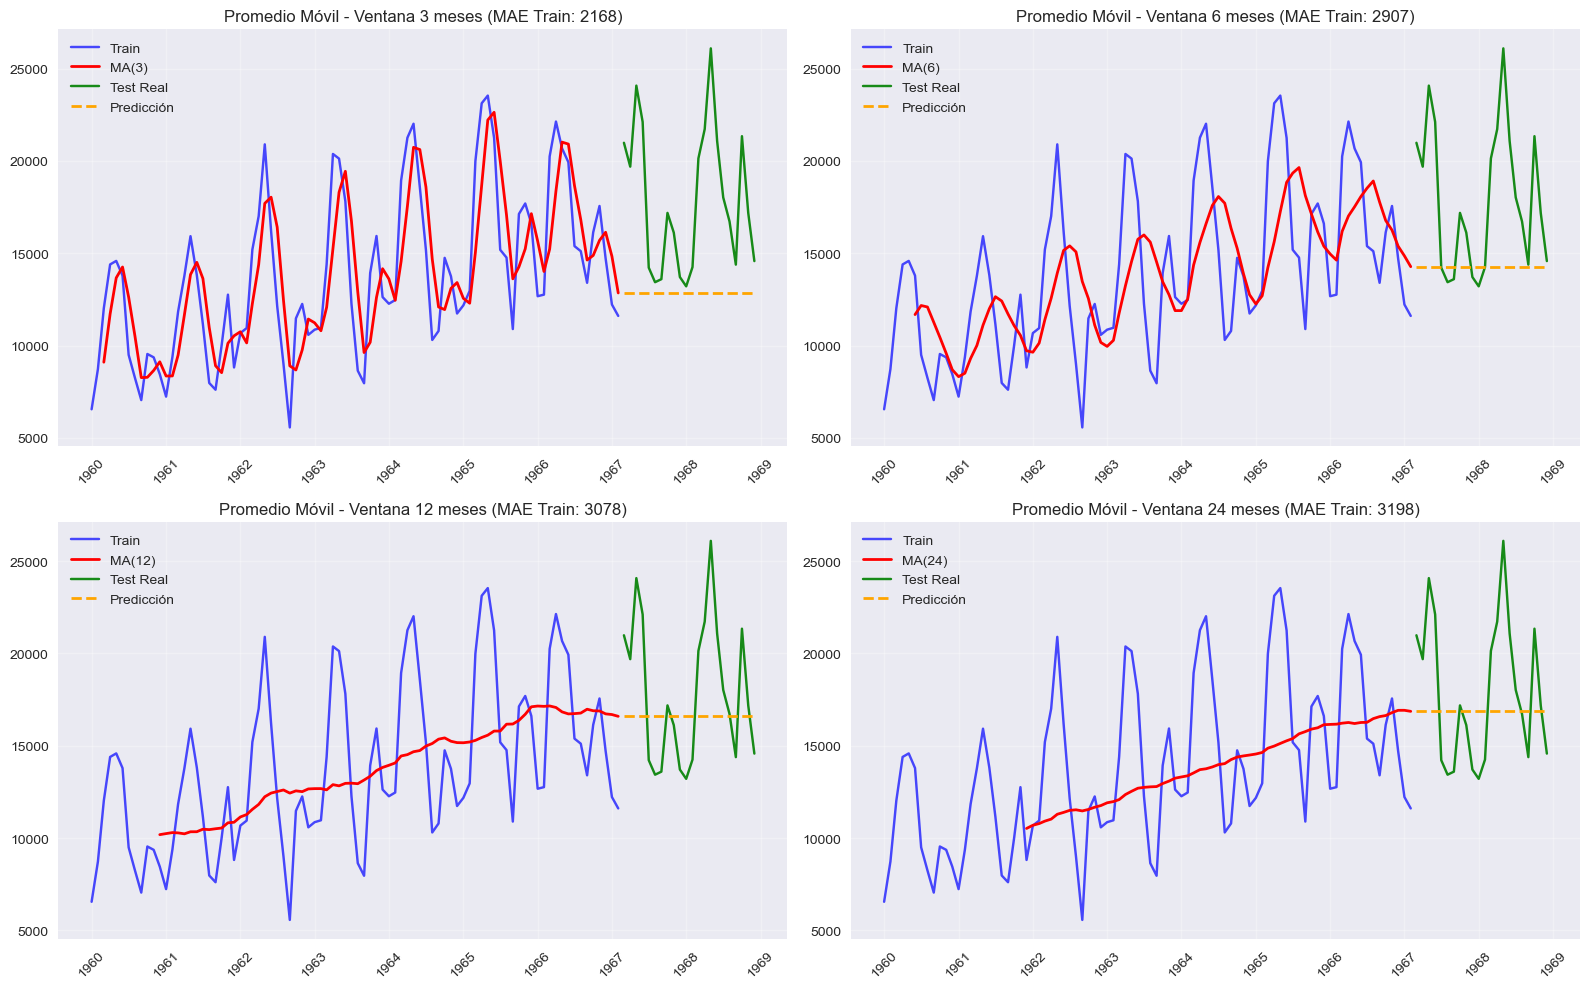

In [4]:
print("\nPROMEDIOS MÓVILES")
print("-" * 30)

windows = [3, 6, 12, 24]  
ma_predictions = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for i, window in enumerate(windows):
    ma = train_data['Sales'].rolling(window=window).mean()
    
    last_ma = ma.iloc[-1]
    prediction = [last_ma] * len(test_data)
    ma_predictions[f'MA_{window}'] = prediction
    
    ma_train = ma.dropna()
    train_subset = train_data['Sales'].iloc[window-1:]
    train_mae = mean_absolute_error(train_subset, ma_train)
    
    axes[i].plot(train_data.index, train_data['Sales'], label='Train', alpha=0.7, color='blue')
    axes[i].plot(train_data.index, ma, label=f'MA({window})', linewidth=2, color='red')
    axes[i].plot(test_data.index, test_data['Sales'], label='Test Real', alpha=0.9, color='green')
    axes[i].plot(test_data.index, prediction, label='Predicción', linewidth=2, linestyle='--', color='orange')
    axes[i].set_title(f'Promedio Móvil - Ventana {window} meses (MAE Train: {train_mae:.0f})')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


ALISAMIENTO EXPONENCIAL
------------------------------


/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


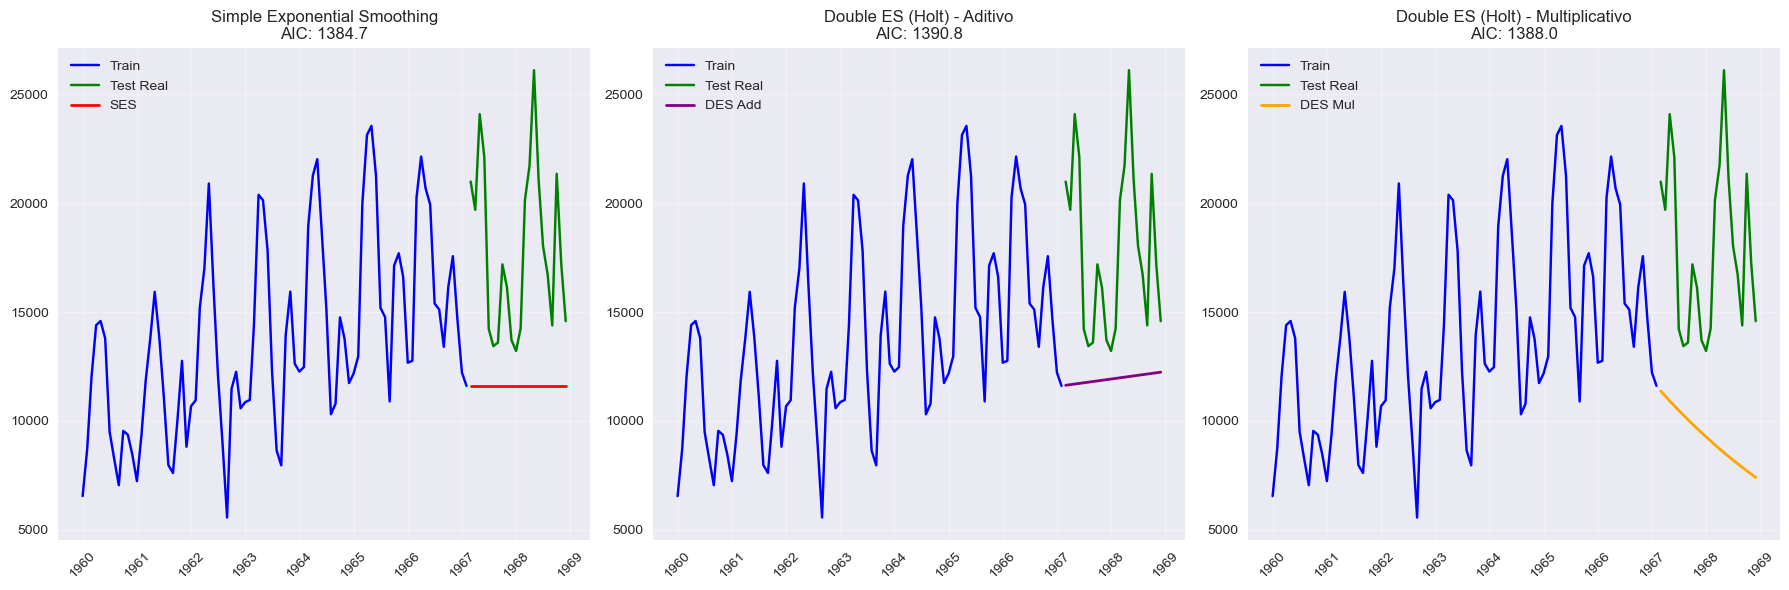

In [5]:
print("\nALISAMIENTO EXPONENCIAL")
print("-" * 30)

ses = ExponentialSmoothing(train_data['Sales'], trend=None, seasonal=None)
ses_fit = ses.fit()
ses_pred = ses_fit.forecast(len(test_data))

des = ExponentialSmoothing(train_data['Sales'], trend='add', seasonal=None)
des_fit = des.fit()
des_pred = des_fit.forecast(len(test_data))

des_mul = ExponentialSmoothing(train_data['Sales'], trend='mul', seasonal=None)
des_mul_fit = des_mul.fit()
des_mul_pred = des_mul_fit.forecast(len(test_data))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
axes[0].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
axes[0].plot(test_data.index, ses_pred, label='SES', linewidth=2, color='red')
axes[0].set_title(f'Simple Exponential Smoothing\nAIC: {ses_fit.aic:.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
axes[1].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
axes[1].plot(test_data.index, des_pred, label='DES Add', linewidth=2, color='purple')
axes[1].set_title(f'Double ES (Holt) - Aditivo\nAIC: {des_fit.aic:.1f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
axes[2].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
axes[2].plot(test_data.index, des_mul_pred, label='DES Mul', linewidth=2, color='orange')
axes[2].set_title(f'Double ES (Holt) - Multiplicativo\nAIC: {des_mul_fit.aic:.1f}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print("\nHOLT-WINTERS")
print("-" * 30)

try:
    hw_add = ExponentialSmoothing(train_data['Sales'], 
                                  trend='add', 
                                  seasonal='add', 
                                  seasonal_periods=12)
    hw_add_fit = hw_add.fit()
    hw_add_pred = hw_add_fit.forecast(len(test_data))
    
    hw_mul = ExponentialSmoothing(train_data['Sales'], 
                                  trend='add', 
                                  seasonal='mul', 
                                  seasonal_periods=12)
    hw_mul_fit = hw_mul.fit()
    hw_mul_pred = hw_mul_fit.forecast(len(test_data))
    
    hw_damped = ExponentialSmoothing(train_data['Sales'], 
                                    trend='add', 
                                    seasonal='mul', 
                                    seasonal_periods=12,
                                    damped_trend=True)
    hw_damped_fit = hw_damped.fit()
    hw_damped_pred = hw_damped_fit.forecast(len(test_data))
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
    axes[0].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
    axes[0].plot(test_data.index, hw_add_pred, label='HW Aditivo', linewidth=2, color='red')
    axes[0].set_title(f'Holt-Winters Aditivo\nAIC: {hw_add_fit.aic:.1f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
    axes[1].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
    axes[1].plot(test_data.index, hw_mul_pred, label='HW Multiplicativo', linewidth=2, color='purple')
    axes[1].set_title(f'Holt-Winters Multiplicativo\nAIC: {hw_mul_fit.aic:.1f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    axes[2].plot(train_data.index, train_data['Sales'], label='Train', color='blue')
    axes[2].plot(test_data.index, test_data['Sales'], label='Test Real', color='green')
    axes[2].plot(test_data.index, hw_damped_pred, label='HW Damped', linewidth=2, color='orange')
    axes[2].set_title(f'Holt-Winters Damped\nAIC: {hw_damped_fit.aic:.1f}')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mejor Holt-Winters por AIC:")
    hw_models = {'Aditivo': hw_add_fit.aic, 'Multiplicativo': hw_mul_fit.aic, 'Damped': hw_damped_fit.aic}
    best_hw = min(hw_models.items(), key=lambda x: x[1])
    print(f"   {best_hw[0]}: AIC = {best_hw[1]:.1f}")
    
except Exception as e:
    print(f"Error en Holt-Winters: {e}")
    hw_add_pred = des_pred  
    hw_mul_pred = des_pred
    hw_damped_pred = des_pred


MODELO SARIMA
------------------------------
🔍 Usando parámetros SARIMA predefinidos...
Modelo SARIMA: SARIMA(1, 1, 1) x (1, 1, 1, 12)


/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/lab_series/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


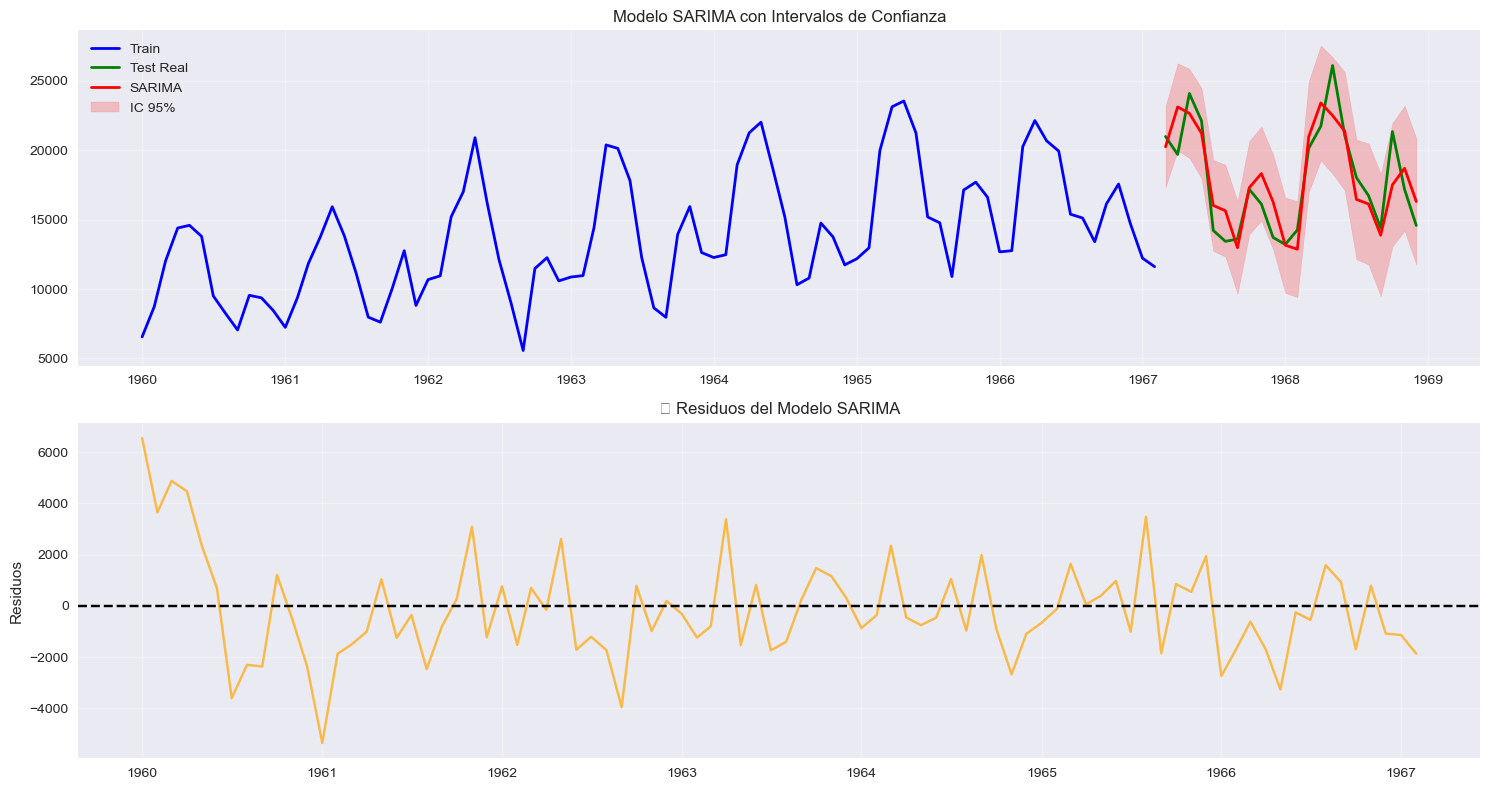

Diagnósticos del modelo SARIMA:
   Modelo utilizado: SARIMA(1, 1, 1) x (1, 1, 1, 12)
Error en SARIMA: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


In [6]:
print("\nMODELO SARIMA")
print("-" * 30)

try:
    print("🔍 Usando parámetros SARIMA predefinidos...")
    
    order = (1, 1, 1)  
    seasonal_order = (1, 1, 1, 12)  
    
    print(f"Modelo SARIMA: SARIMA{order} x {seasonal_order}")
    
    
    sarima_model = SARIMAX(train_data['Sales'],
                           order=order,
                           seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.forecast(len(test_data))
    
    sarima_pred_ci = sarima_fit.get_forecast(len(test_data))
    sarima_conf_int = sarima_pred_ci.conf_int()
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_data.index, train_data['Sales'], label='Train', color='blue', linewidth=2)
    plt.plot(test_data.index, test_data['Sales'], label='Test Real', color='green', linewidth=2)
    plt.plot(test_data.index, sarima_pred, label='SARIMA', linewidth=2, color='red')
    plt.fill_between(test_data.index, 
                     sarima_conf_int.iloc[:, 0], 
                     sarima_conf_int.iloc[:, 1], 
                     color='red', alpha=0.2, label='IC 95%')
    plt.title('Modelo SARIMA con Intervalos de Confianza')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    residuos = sarima_fit.resid
    plt.plot(train_data.index, residuos, color='orange', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.title('🎯 Residuos del Modelo SARIMA')
    plt.ylabel('Residuos')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Diagnósticos del modelo SARIMA:")
    print(f"   Modelo utilizado: SARIMA{order} x {seasonal_order}")
    print(f"   Test Ljung-Box (p-value): {sarima_fit.test_serial_correlation('ljungbox')[0]['lb_pvalue']:.4f}")
    print(f"   AIC: {sarima_fit.aic:.1f}")
    print(f"   BIC: {sarima_fit.bic:.1f}")
    
except Exception as e:
    print(f"Error en SARIMA: {e}")
    sarima_pred = des_pred  


MODELO PROPHET
------------------------------


19:51:02 - cmdstanpy - INFO - Chain [1] start processing
19:51:02 - cmdstanpy - INFO - Chain [1] done processing


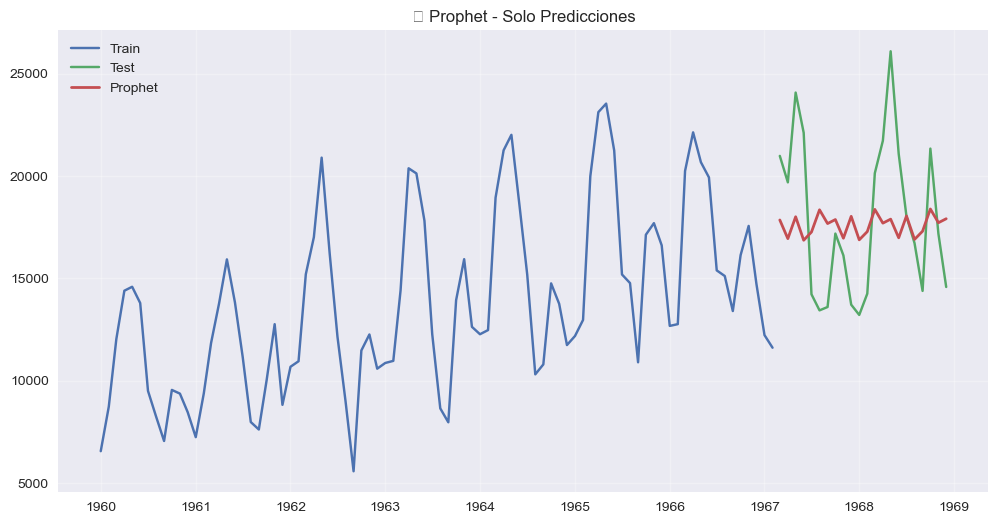

Prophet funcionó correctamente


In [ ]:
print("\nMODELO PROPHET")
print("-" * 30)

PROPHET_AVAILABLE = True

if PROPHET_AVAILABLE:
    try:
        prophet_train = pd.DataFrame({
            'ds': train_data.index,
            'y': train_data['Sales'].values
        })
        
        prophet_train = prophet_train.dropna()
        
        prophet_model = Prophet(
            yearly_seasonality=False,  
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'  
        )
        
        prophet_model.fit(prophet_train)
        
        future_dates = pd.date_range(
            start=test_data.index[0], 
            periods=len(test_data), 
            freq='D'
        )
        future_df = pd.DataFrame({'ds': future_dates})
        prophet_forecast = prophet_model.predict(future_df)
        prophet_pred = prophet_forecast['yhat'].values
        
        plt.figure(figsize=(12, 6))
        plt.plot(train_data.index, train_data['Sales'], label='Train')
        plt.plot(test_data.index, test_data['Sales'], label='Test')
        plt.plot(test_data.index, prophet_pred, label='Prophet', linewidth=2)
        plt.title('🔮 Prophet - Solo Predicciones')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        
    except Exception as e:
        print(f"Error en Prophet: {e}")
        prophet_pred = ses_pred
else:
    prophet_pred = ses_pred



EVALUACIÓN Y COMPARACIÓN
------------------------------
RESULTADOS DE EVALUACIÓN:
  Model     MAE    RMSE  MAPE  Direction_Acc
Prophet 3175.05 3733.28 17.96          61.90
  MA_12 3294.77 3983.08 17.59           0.00
   MA_3 5052.68 6299.46 25.09           0.00
DES_Add 5966.03 7063.23 30.40          38.10
 SARIMA 5966.03 7063.23 30.40          38.10
    SES 6295.68 7334.11 32.34           0.00
DES_Mul 8648.52 9463.75 46.14          61.90


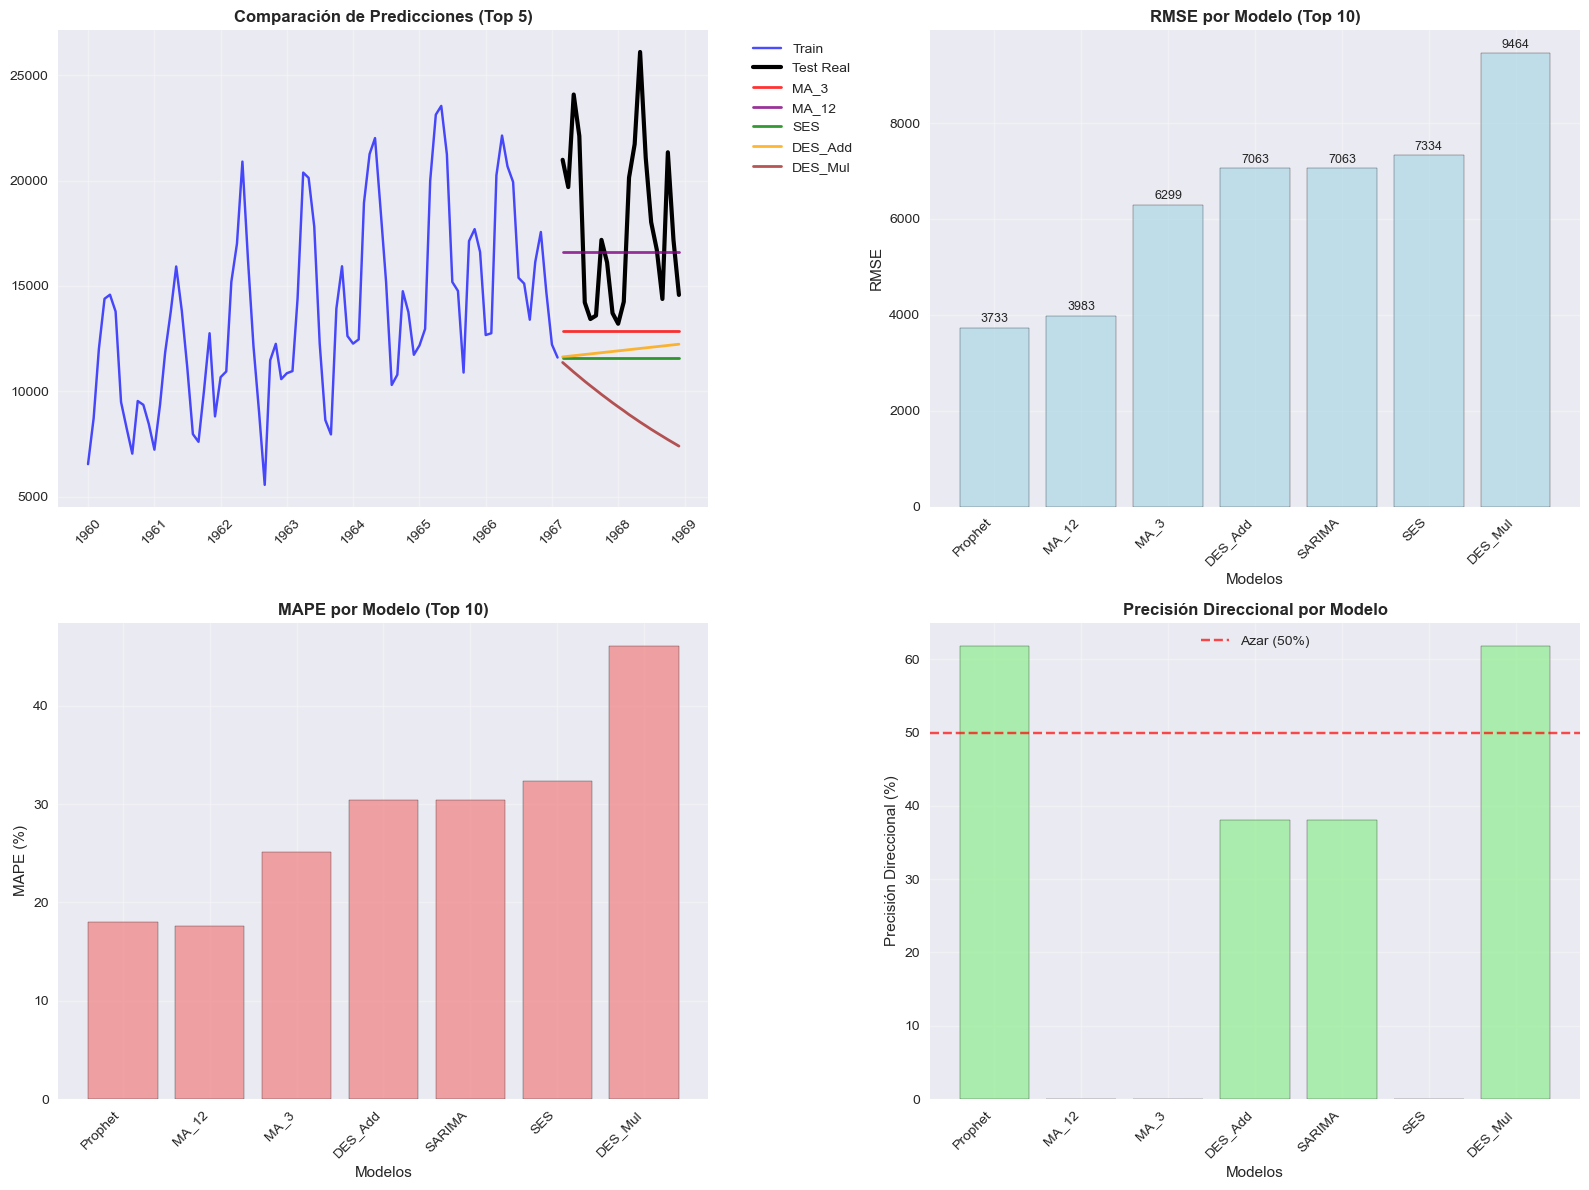

In [18]:
print("\nEVALUACIÓN Y COMPARACIÓN")
print("-" * 30)

def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)
    direction_accuracy = np.mean(np.sign(actual_diff) == np.sign(pred_diff)) * 100
    
    return {
        'Model': model_name, 
        'MAE': mae, 
        'RMSE': rmse, 
        'MAPE': mape,
        'Direction_Acc': direction_accuracy
    }

predictions = {
    'MA_3': ma_predictions.get('MA_3', [np.mean(train_data['Sales'])] * len(test_data)),
    'MA_12': ma_predictions.get('MA_12', [np.mean(train_data['Sales'])] * len(test_data)),
    'SES': ses_pred,
    'DES_Add': des_pred,
    'DES_Mul': des_mul_pred,
    'SARIMA': sarima_pred,
    'Prophet': prophet_pred
}

results = []
for name, pred in predictions.items():
    try:
        if len(pred) == len(test_data['Sales']):
            metrics = calculate_metrics(test_data['Sales'].values, pred, name)
            results.append(metrics)
    except Exception as e:
        print(f"Error calculando métricas para {name}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("RESULTADOS DE EVALUACIÓN:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.2f'))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0,0].plot(train_data.index, train_data['Sales'], label='Train', alpha=0.7, color='blue')
axes[0,0].plot(test_data.index, test_data['Sales'], label='Test Real', linewidth=3, color='black')

colors = ['red', 'purple', 'green', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'yellow']
for i, (name, pred) in enumerate(list(predictions.items())[:5]):  
    axes[0,0].plot(test_data.index, pred, label=name, linewidth=2, 
                   color=colors[i % len(colors)], alpha=0.8)

axes[0,0].set_title('Comparación de Predicciones (Top 5)', fontsize=12, fontweight='bold')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

top_10 = results_df.head(10) if len(results_df) > 10 else results_df
x_pos = np.arange(len(top_10))
bars = axes[0,1].bar(x_pos, top_10['RMSE'], alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].set_xlabel('Modelos')
axes[0,1].set_ylabel('RMSE')
axes[0,1].set_title('RMSE por Modelo (Top 10)', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(top_10['Model'], rotation=45, ha='right')
axes[0,1].grid(True, alpha=0.3)

for bar, rmse in zip(bars, top_10['RMSE']):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                   f'{rmse:.0f}', ha='center', va='bottom', fontsize=9)

bars = axes[1,0].bar(x_pos, top_10['MAPE'], alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_xlabel('Modelos')
axes[1,0].set_ylabel('MAPE (%)')
axes[1,0].set_title('MAPE por Modelo (Top 10)', fontsize=12, fontweight='bold')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(top_10['Model'], rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

bars = axes[1,1].bar(x_pos, top_10['Direction_Acc'], alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].set_xlabel('Modelos')
axes[1,1].set_ylabel('Precisión Direccional (%)')
axes[1,1].set_title('Precisión Direccional por Modelo', fontsize=12, fontweight='bold')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(top_10['Model'], rotation=45, ha='right')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Azar (50%)')
axes[1,1].legend()

plt.tight_layout()
plt.show()


ANÁLISIS DE RESIDUOS DEL MEJOR MODELO
Analizando residuos de: Prophet


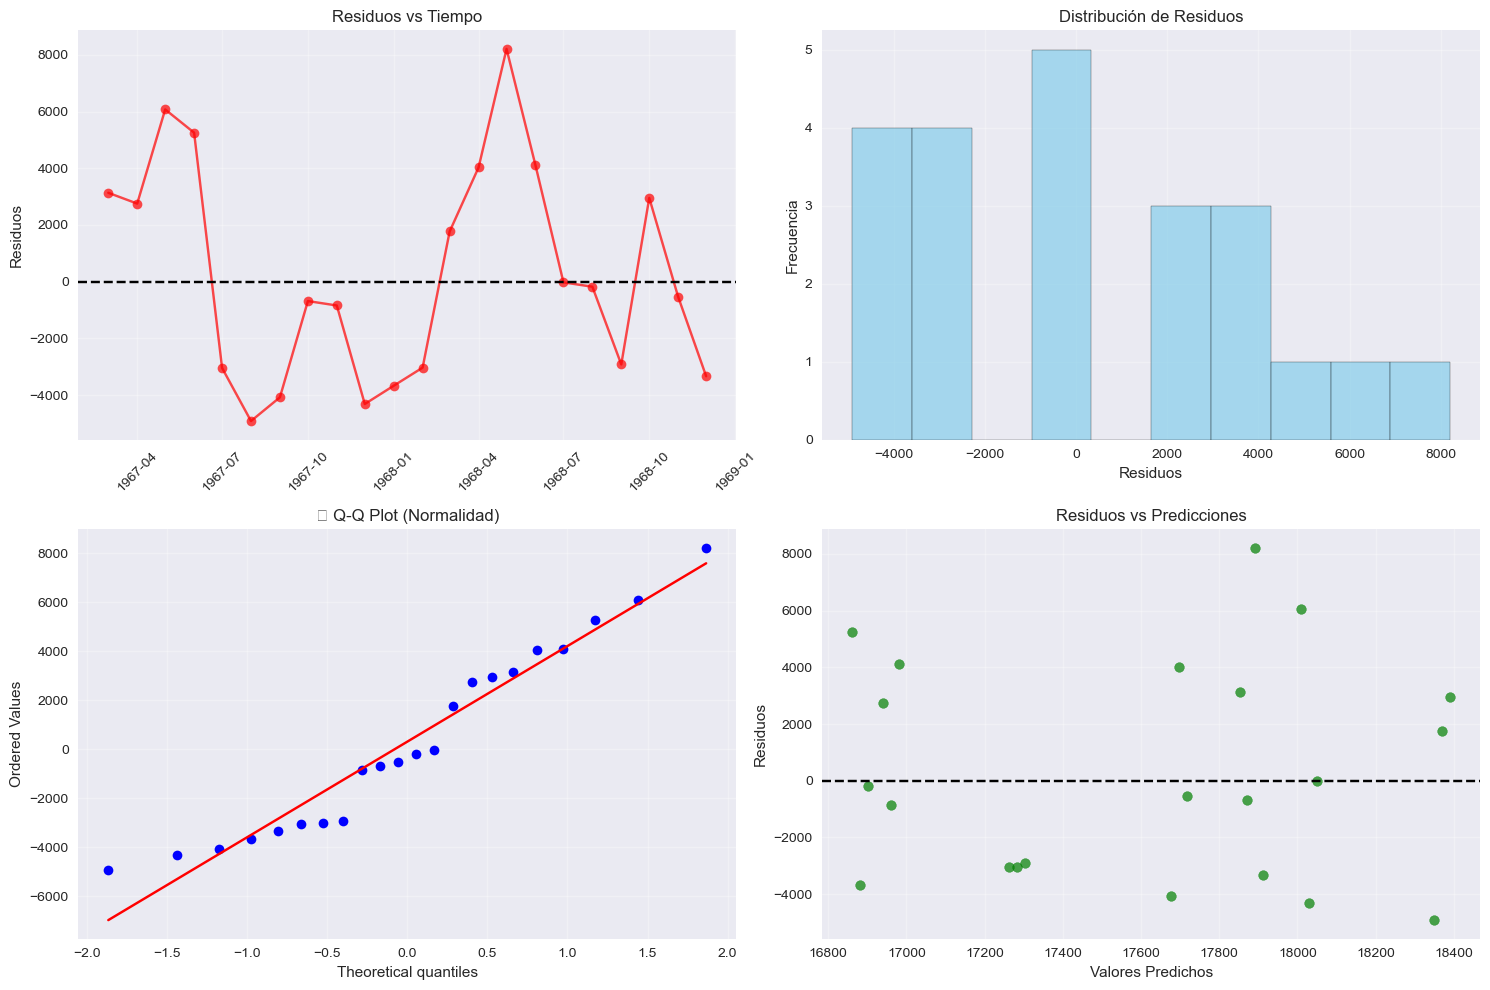

Estadísticas de residuos:
   Media: 303.83
   Desviación estándar: 3720.90
   Error absoluto medio: 3175.05
   Error relativo medio: 17.96%
   Test Shapiro-Wilk (normalidad): p-value = 0.1931
     Residuos normales


In [22]:
print("\nANÁLISIS DE RESIDUOS DEL MEJOR MODELO")
print("=" * 50)

best_model = results_df.iloc[0]
best_pred_name = best_model['Model']
best_pred = predictions[best_pred_name]

print(f"Analizando residuos de: {best_pred_name}")

residuos = test_data['Sales'].values - best_pred
residuos_relativos = residuos / test_data['Sales'].values * 100

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(test_data.index, residuos, 'o-', color='red', alpha=0.7)
axes[0,0].axhline(y=0, color='black', linestyle='--')
axes[0,0].set_title('Residuos vs Tiempo')
axes[0,0].set_ylabel('Residuos')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

axes[0,1].hist(residuos, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].set_title('Distribución de Residuos')
axes[0,1].set_xlabel('Residuos')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1,0])
axes[1,0].set_title('📈 Q-Q Plot (Normalidad)')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(best_pred, residuos, alpha=0.7, color='green')
axes[1,1].axhline(y=0, color='black', linestyle='--')
axes[1,1].set_title('Residuos vs Predicciones')
axes[1,1].set_xlabel('Valores Predichos')
axes[1,1].set_ylabel('Residuos')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estadísticas de residuos:")
print(f"   Media: {np.mean(residuos):.2f}")
print(f"   Desviación estándar: {np.std(residuos):.2f}")
print(f"   Error absoluto medio: {np.mean(np.abs(residuos)):.2f}")
print(f"   Error relativo medio: {np.mean(np.abs(residuos_relativos)):.2f}%")

shapiro_stat, shapiro_p = stats.shapiro(residuos)
print(f"   Test Shapiro-Wilk (normalidad): p-value = {shapiro_p:.4f}")
print(f"     {'Residuos normales' if shapiro_p > 0.05 else 'Residuos no normales'}")


In [23]:
print("\nCONCLUSIONES Y ANÁLISIS")
print("=" * 50)

print(f"Mejor modelo: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.0f} unidades")
print(f"   MAE: {best_model['MAE']:.0f} unidades")
print(f"   MAPE: {best_model['MAPE']:.2f}%")
print(f"   Precisión Direccional: {best_model['Direction_Acc']:.1f}%")




CONCLUSIONES Y ANÁLISIS
Mejor modelo: Prophet
   RMSE: 3733 unidades
   MAE: 3175 unidades
   MAPE: 17.96%
   Precisión Direccional: 61.9%
